In [1]:
%run Imports.ipynb

In [2]:
conf = pyspark.SparkConf()
spark = SparkSession.builder.appName("Rank").getOrCreate()

23/03/29 10:44:22 WARN Utils: Your hostname, localhost resolves to a loopback address: 127.0.0.1; using 10.0.0.124 instead (on interface en0)
23/03/29 10:44:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/29 10:44:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/29 10:44:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
df1=spark.read.parquet("/Users/rose/Documents/CleanDuneData/*")

In [4]:
df1.count()

3898970

In [5]:
df1.createOrReplaceTempView("Load")

In [6]:
df_rule_1 = spark.sql("SELECT buyer, AVG(usd_amount) AS buying_power, COUNT(buyer) AS txn_buy FROM Load GROUP BY buyer")

In [7]:
df_rule_1.show()

+--------------------+------------------+-------+
|               buyer|      buying_power|txn_buy|
+--------------------+------------------+-------+
|\x4623b7a9eb459fd...|       2970.340307|     10|
|\xa3d773e4f9080ae...|466.26832299999995|      5|
|\x3c5b3a8287f759e...| 2.246813566666667|      3|
|\xb738397f0a03aa5...|         58.711685|      2|
|\x1386d7a006bd547...| 762.9974736110116|     31|
|\xc38d773623dbb7b...|1020.3994119999999|     12|
|\x2e43850af79290f...|         5.4629215|      4|
|\x4299b157abde3ef...|        153.630215|      2|
|\xfc2dd34349f9abd...|          674.5711|      3|
|\x08dd1e75fe3a46c...|     2222.25308322|     10|
|\x0cb540e8a237e57...|1207.6800986666665|      3|
|\x20f6db36863d7a5...| 560.1388333333333|      3|
|\x1bd93fb42ea6a03...| 678.9134799999999|      2|
|\x6b937c85f26d6b0...| 514.5364943333333|      6|
|\xa800f34505e8b34...|       6379.152486|      4|
|\x8ba659f0be00b59...|284.57286472403683|      6|
|\x09328f42f0bc356...|          39.09095|      2|


# holding query

In [108]:
df_holding = spark.sql("WITH buyer_table AS (SELECT buyer, nft_token_id, nft_contract_address, original_amount, usd_amount, block_time FROM load WHERE original_amount > 0.0 AND trade_type = 'Single Item Trade'), seller_table AS (SELECT seller, nft_token_id, nft_contract_address, original_amount, usd_amount, block_time FROM load WHERE original_amount > 0.0 AND trade_type = 'Single Item Trade') SELECT buyer_table.buyer as person, buyer_table.nft_token_id, buyer_table.original_amount as buy_price, seller_table.original_amount as sell_price, seller_table.original_amount - buyer_table.original_amount as eth_profit, seller_table.usd_amount - buyer_table.usd_amount as usd_profit, buyer_table.block_time as buy_time, seller_table.block_time as sell_time FROM buyer_table INNER JOIN seller_table on buyer_table.buyer = seller_table.seller AND buyer_table.nft_token_id = seller_table.nft_token_id AND buyer_table.nft_contract_address = seller_table.nft_contract_address")
#Calculating timestamp difference and converting to seconds
df_holding2 = df_holding.withColumn("holding_duration", (unix_timestamp(col("sell_time")) - unix_timestamp(col("buy_time"))))
#selecting the two columns from df_holding2 dataframe
from pyspark.sql.functions import abs
df_holding3 = df_holding2.select("person","holding_duration")
df_holding3= df_holding3.withColumn("holding_duration", abs(df_holding3.holding_duration))
df_holding3_pd=df_holding3.toPandas()
hist, bins=pd.cut(df_holding3_pd['holding_duration'],bins=100,labels=False,retbins=True,right=False)
df_holding3_pd['Score6']=hist
df_holding3_pd['Score6']+=1
print(df_holding3_pd)
#converting to sparkdf
df_rule_holding=spark.createDataFrame(df_holding3_pd)

                                            person  holding_duration  Score6
0       \x0000005c7dc69d405f09aaadca29068d4f88cde8            298840       1
1       \x00003e81818a2f1e1ffc41dc47d4b1716110b90a             37944       1
2       \x000422a87d6882570ca0f510e8756b20ee125000           1145188       2
3       \x000422a87d6882570ca0f510e8756b20ee125000           1008993       1
4       \x000422a87d6882570ca0f510e8756b20ee125000            210733       1
...                                            ...               ...     ...
642628  \xffd88c6bf8c53b6c56a216cd1ca34c3f87486fd4           2080771       3
642629  \xffe4261a55f4d5ae916d1130ce4d9132f9adb262           7925204       8
642630  \xffea87fc3026d91896ec85d873b13b25e8b182cb           2933325       3
642631  \xfffb4e05ff7e83fb1329d740474ea8bb5c548b93            780259       1
642632  \xfffef84688fd0248155d06c0e603a04adabccc64           4979682       5

[642633 rows x 3 columns]


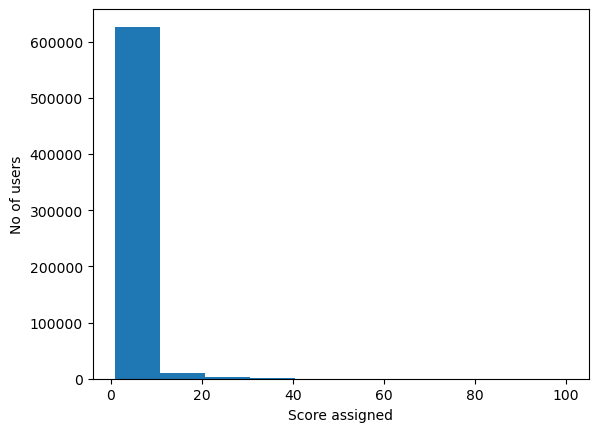

[  1   2   3   5   7   8   9   6   4  20  13  18  31  17  10  12  11  21
  16  28  29  27  14  37  25  19  24  34  26  15  30  22  23  41  51  50
  32  44  40  35  36  42  45  33  49  56  65  46  43  38  48  55  62  74
  59  47  39  68  71  63  54  85  77  66  53  67  58  83  60  69  75  61
  57  72  52  84  90  70 100  94  93  86  80]


In [87]:
plt.hist(df_holding3_pd["Score6"])
plt.xlabel("Score assigned")
plt.ylabel("No of users")
plt.title("")
plt.show()
print(df_holding3_pd['Score6'].unique())

# rest of information query

In [16]:
df_all = spark.sql("SELECT * FROM ( SELECT n1.buyer, n1.original_currency, n1.nft_token_id, n1.nft_contract_address, n1.original_amount as Bought, n2.original_amount as Sold, n1.block_time as Bought_Timestamp, n2.block_time as Sold_Timestamp,n1.usd_amount as Bought_amount, n2.usd_amount as Sold_amount, (n2.usd_amount - n1.usd_amount) as net, n1.platform as n1platform, n2.platform as n2platform FROM Load n1, Load n2 where n1.buyer = n2.seller AND  n2.block_time > n1.block_time AND  n1.nft_token_id is not null AND n1.nft_token_id = n2.nft_token_id AND n1.nft_contract_address = n2.nft_contract_address) holdings")

In [17]:
df_all.columns

['buyer',
 'original_currency',
 'nft_token_id',
 'nft_contract_address',
 'Bought',
 'Sold',
 'Bought_Timestamp',
 'Sold_Timestamp',
 'Bought_amount',
 'Sold_amount',
 'net',
 'n1platform',
 'n2platform']

In [18]:
df_all.schema

StructType([StructField('buyer', StringType(), True), StructField('original_currency', StringType(), True), StructField('nft_token_id', StringType(), True), StructField('nft_contract_address', StringType(), True), StructField('Bought', DoubleType(), True), StructField('Sold', DoubleType(), True), StructField('Bought_Timestamp', TimestampType(), True), StructField('Sold_Timestamp', TimestampType(), True), StructField('Bought_amount', DoubleType(), True), StructField('Sold_amount', DoubleType(), True), StructField('net', DoubleType(), True), StructField('n1platform', StringType(), True), StructField('n2platform', StringType(), True)])

In [19]:
type(df_all)

pyspark.sql.dataframe.DataFrame

In [20]:
df_all.select('buyer','Bought_amount','Sold_amount','net').show(20)

+--------------------+-------------+------------+-------------------+
|               buyer|Bought_amount| Sold_amount|                net|
+--------------------+-------------+------------+-------------------+
|\x0000005c7dc69d4...|    837.48308|    1078.273| 240.78991999999994|
|\x00003e81818a2f1...|   125.698549|  173.522188|          47.823639|
|\x0005bb8bdcbbf4a...|     775.9004|   1133.2491|           357.3487|
|\x00079e801ad1382...|    178.37568|   1289.0346| 1110.6589199999999|
|\x000cd27f10dffac...|     1405.935|   55277.167|          53871.232|
|\x000cef8f0ab0a2f...|    694.86968|1094.2062762| 399.33659620000003|
|\x000e0ed8a7307e1...|      905.931|   519.35032|-386.58068000000003|
|\x00110e09134aec0...|   200.720832|   188.68224|-12.038591999999994|
|\x00110e09134aec0...|   200.720832|  250.395432|            49.6746|
|\x00110e09134aec0...|   200.720832|   278.09376|  77.37292799999997|
|\x00110e09134aec0...|   200.720832|  248.424224|  47.70339200000001|
|\x00110e09134aec0..

# Ranking 1 - average amount spent (here profit , loss automatically done)

23/03/29 14:20:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:20:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:20:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:20:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:20:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:20:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:20:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:20:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 14:20:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:20:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:20:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:20:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:20:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:20:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:20:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:20:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:20:25 WARN RowBasedKeyValueBatch: Calling spill() on

                                             buyer    avg_spent  Score1
0       \x006b82530c7985fd0084382e866db39a6c5c0578  -252.267914      27
1       \x014fd068938fa1965be36a9244ddf6d37f6b88cb    89.940925      27
2       \x01981e7284ade335883f75927fae1b70fac44d71  -128.700244      27
3       \x0312b9e6627d9a49cf07a3b5af1f18ad8d8e39db  1866.865157      27
4       \x05379b307e6ae02e522fb134fad1254a4e7fbac1   -80.200510      27
...                                            ...          ...     ...
186030  \xe25cf7322526cfef5ca841deb14323f9ada1234a  1839.846200      27
186031  \xe282780e50937a2490831e4539bbb5f3f564e004  -588.149493      27
186032  \xe73a7a0d3163d12ddf749c97433fac227e4cec3d   137.396000      27
186033  \xed1efb8184a6d9498e98695087da3903376b925a -3484.871500      27
186034  \xf49b67a2b2fc0904cb12a2c41c7d2007841c04a0    97.844091      27

[186035 rows x 3 columns]
[ 27  26  29  28  23  30  37  19  40  22  24  33  32  25  54  35  14  92
  39  31  34  21  18  36  45  44  38

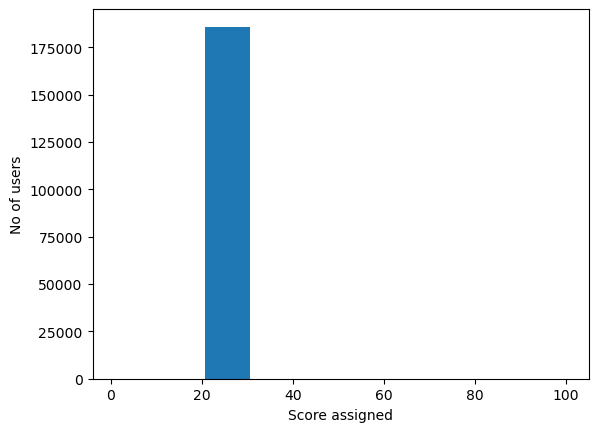

In [85]:
df_avg = df_all.groupBy("buyer").agg(avg("net").alias("avg_spent"))
# score1 based on avg_spent
df_rule_avg_spent_pd=df_avg.toPandas()
hist, bins=pd.cut(df_rule_avg_spent_pd['avg_spent'],bins=100,labels=False,retbins=True,right=False)
df_rule_avg_spent_pd['Score1']=hist
df_rule_avg_spent_pd['Score1']+=1
print(df_rule_avg_spent_pd)
print(df_rule_avg_spent_pd['Score1'].unique())
plt.hist(df_rule_avg_spent_pd["Score1"])
plt.xlabel("Score assigned")
plt.ylabel("No of users")
plt.title("")
plt.show()
#converting to sparkdf
df_rule_avg_spent=spark.createDataFrame(df_rule_avg_spent_pd)

# Ranking 2 - number of transactions

23/03/29 14:49:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:49:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:49:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:49:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:49:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:49:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:49:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:49:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 14:49:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:49:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:49:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:49:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:49:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:49:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:49:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:49:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:49:16 WARN RowBasedKeyValueBatch: Calling spill() on

23/03/29 14:49:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


                                             buyer  number_txns  Score2
0       \x006b82530c7985fd0084382e866db39a6c5c0578           12       2
1       \x014fd068938fa1965be36a9244ddf6d37f6b88cb           19       3
2       \x01981e7284ade335883f75927fae1b70fac44d71           18       3
3       \x0312b9e6627d9a49cf07a3b5af1f18ad8d8e39db            6       1
4       \x03a3da04bd4a888ed473a9c6bd90a13165f78e72            1       1
...                                            ...          ...     ...
186030  \xe0d3851eb01cde810436a054f4211e31a2fe0a82            1       1
186031  \xe25cf7322526cfef5ca841deb14323f9ada1234a            1       1
186032  \xe282780e50937a2490831e4539bbb5f3f564e004            2       1
186033  \xe73a7a0d3163d12ddf749c97433fac227e4cec3d            1       1
186034  \xf49b67a2b2fc0904cb12a2c41c7d2007841c04a0            1       1

[186035 rows x 3 columns]
[  2   3   1   5   8   4   6  12   9  17  10  11  26  15   7  19  20  14
  13  22  29  30  38  27  21  54  18

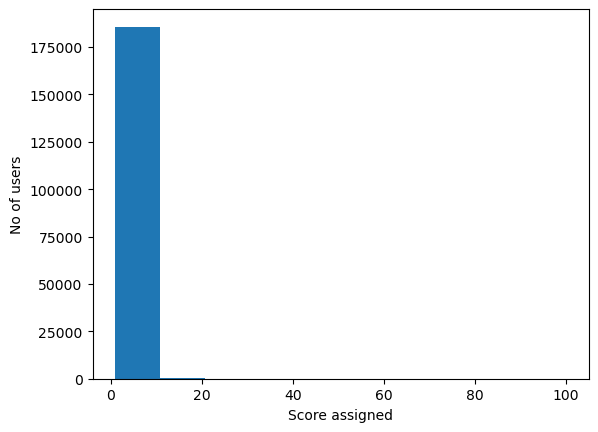

In [95]:
df_count = df_all.groupBy("buyer").agg(count("*").alias("number_txns"))
# score2 based on number_txns
df_rule_number_txns_pd=df_count.toPandas()
hist, bins=pd.cut(df_rule_number_txns_pd['number_txns'],bins=100,labels=False,retbins=True,right=False)
df_rule_number_txns_pd['Score2']=hist
df_rule_number_txns_pd['Score2']+=1
print(df_rule_number_txns_pd)
#print unique score2 values assigned
print(df_rule_number_txns_pd['Score2'].unique())
#plot histogram
plt.hist(df_rule_number_txns_pd["Score2"])
plt.xlabel("Score assigned")
plt.ylabel("No of users")
plt.title("")
plt.show()
#converting to sparkdf
df_rule_number_txns=spark.createDataFrame(df_rule_number_txns_pd)

# Diversity Ranking 3 - Number of Nft contract address held

23/03/29 14:51:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:51:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:51:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:51:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:51:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:51:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:51:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:51:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 14:51:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:51:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:51:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:51:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:51:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:51:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:51:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:51:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:51:41 WARN RowBasedKeyValueBatch: Calling spill() on

                                             buyer  num_nftcontract  Score3
0       \x006b82530c7985fd0084382e866db39a6c5c0578               12       2
1       \x014fd068938fa1965be36a9244ddf6d37f6b88cb               19       3
2       \x01981e7284ade335883f75927fae1b70fac44d71               18       3
3       \x0312b9e6627d9a49cf07a3b5af1f18ad8d8e39db                6       1
4       \x03a3da04bd4a888ed473a9c6bd90a13165f78e72                1       1
...                                            ...              ...     ...
186030  \xe0d3851eb01cde810436a054f4211e31a2fe0a82                1       1
186031  \xe25cf7322526cfef5ca841deb14323f9ada1234a                1       1
186032  \xe282780e50937a2490831e4539bbb5f3f564e004                2       1
186033  \xe73a7a0d3163d12ddf749c97433fac227e4cec3d                1       1
186034  \xf49b67a2b2fc0904cb12a2c41c7d2007841c04a0                1       1

[186035 rows x 3 columns]
[  2   3   1   5   8   4   6  12   9  17  10  11  26  15   7 

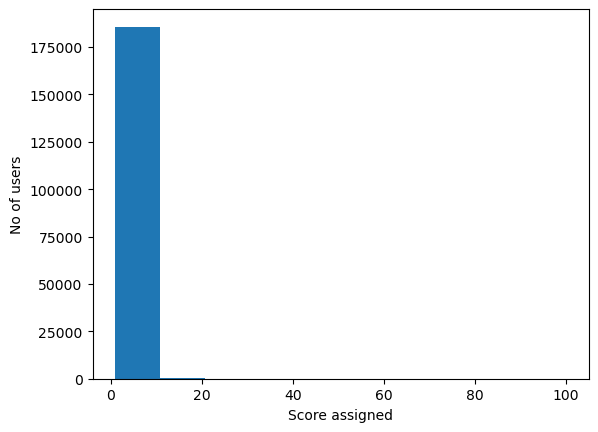

In [96]:
df_num_nftcontract = df_all.groupBy("buyer").agg(count("nft_contract_address").alias("num_nftcontract"))
# score3 based on num_nftcontract
df_rule_num_nftcontract_pd=df_num_nftcontract.toPandas()
hist, bins=pd.cut(df_rule_num_nftcontract_pd['num_nftcontract'],bins=100,labels=False,retbins=True,right=False)
df_rule_num_nftcontract_pd['Score3']=hist
df_rule_num_nftcontract_pd['Score3']+=1
print(df_rule_num_nftcontract_pd)
#print unique score3 values assigned
print(df_rule_num_nftcontract_pd['Score3'].unique())
#plot histogram
plt.hist(df_rule_num_nftcontract_pd["Score3"])
plt.xlabel("Score assigned")
plt.ylabel("No of users")
plt.title("")
plt.show()
#converting to sparkdf
df_rule_num_nftcontract=spark.createDataFrame(df_rule_num_nftcontract_pd)

# Diversity Ranking 4 - Number of unique currencies transaction done in

In [24]:
unique_names = df_all.select(col("original_currency")).distinct().rdd.flatMap(lambda x: x).collect()

                                             buyer  num_currency  Score4
0       \x375751f0159c9bb29ec2945a5767bb9d3874712f             1       1
1       \x3bd12ee645be8734170c4e7a86448a410903eaed             1       1
2       \xf9e5db0610350385f83e6290e040fe99365548da             1       1
3       \x1773fb4569491ccd6da5f4eed8359bf61f9bf095             1       1
4       \x890652186e45f7be558eadfdde949307249a47f0             1       1
...                                            ...           ...     ...
186030  \xe73a7a0d3163d12ddf749c97433fac227e4cec3d             1       1
186031  \xb40cab161bf5f5f0669ce661c7d9d6e269461d9a             1       1
186032  \x69942f8e403b9d505e2da8a7a2056d9638805dcd             1       1
186033  \x7a44d5004b9498534c44c5fe21620e183f13546d             1       1
186034  \xc5bd99f6fd29d26beba91a171d519107c6d60201             1       1

[186035 rows x 3 columns]
[  1  34  67 100]


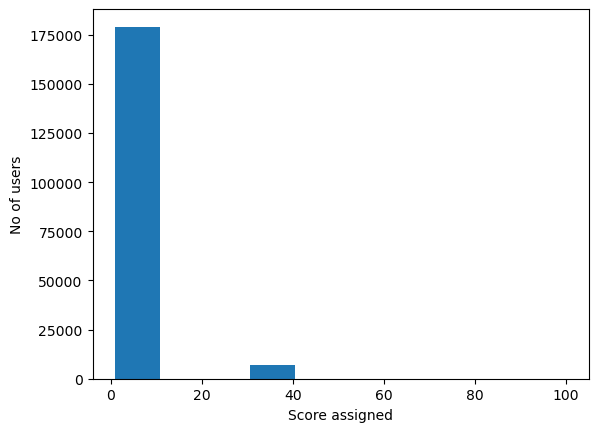

In [97]:
# df_currency = df_all.groupBy("buyer").agg(countDistinct("original_currency").alias("num_currency")).orderBy(desc("num_currency"))
df_currency = df_all.groupBy("buyer").agg(countDistinct("original_currency").alias("num_currency"))
# score4 based on num_currency
df_rule_num_currency_pd=df_currency.toPandas()
hist, bins=pd.cut(df_rule_num_currency_pd['num_currency'],bins=100,labels=False,retbins=True,right=False)
df_rule_num_currency_pd['Score4']=hist
df_rule_num_currency_pd['Score4']+=1
print(df_rule_num_currency_pd)
#print unique score4 values assigned
print(df_rule_num_currency_pd['Score4'].unique())
#plot histogram
plt.hist(df_rule_num_currency_pd["Score4"])
plt.xlabel("Score assigned")
plt.ylabel("No of users")
plt.title("")
plt.show()
#converting back to spark df
df_rule_num_currency=spark.createDataFrame(df_rule_num_currency_pd)

In [26]:
# data_collect = df_all.collect()

# Diversity Ranking 5 - Average Duration (in seconds)

In [27]:
# df_all = df_all.withColumn("duration", (col("Sold_Timestamp") - col("Bought_Timestamp")))
df_all = df_all.withColumn("duration", (unix_timestamp(col("Sold_Timestamp")) - unix_timestamp(col("Bought_Timestamp"))))

In [28]:
df_all.select('duration').show(5)

+--------+
|duration|
+--------+
|  298840|
|   37944|
|   91081|
| 4252760|
| 6705652|
+--------+
only showing top 5 rows



23/03/29 14:53:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:53:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:53:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:53:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:53:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:53:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:53:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:53:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 14:53:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:54:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:54:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:54:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:54:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:54:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:54:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:54:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 14:54:00 WARN RowBasedKeyValueBatch: Calling spill() on

23/03/29 14:54:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


                                             buyer  avg_duration  Score5
0       \x006b82530c7985fd0084382e866db39a6c5c0578  3.849958e+06       5
1       \x014fd068938fa1965be36a9244ddf6d37f6b88cb  1.528443e+06       2
2       \x01981e7284ade335883f75927fae1b70fac44d71  8.420664e+05       1
3       \x0312b9e6627d9a49cf07a3b5af1f18ad8d8e39db  2.391315e+06       3
4       \x03a3da04bd4a888ed473a9c6bd90a13165f78e72  8.280000e+02       1
...                                            ...           ...     ...
186030  \xe0d3851eb01cde810436a054f4211e31a2fe0a82  1.754641e+06       2
186031  \xe25cf7322526cfef5ca841deb14323f9ada1234a  5.060740e+05       1
186032  \xe282780e50937a2490831e4539bbb5f3f564e004  6.212410e+05       1
186033  \xe73a7a0d3163d12ddf749c97433fac227e4cec3d  9.421300e+04       1
186034  \xf49b67a2b2fc0904cb12a2c41c7d2007841c04a0  1.046440e+07      12

[186035 rows x 3 columns]
[  5   2   1   3   9   8   4   6  34  27   7  15  13  17  16  10  12  29
  21  19  14  24  11  18

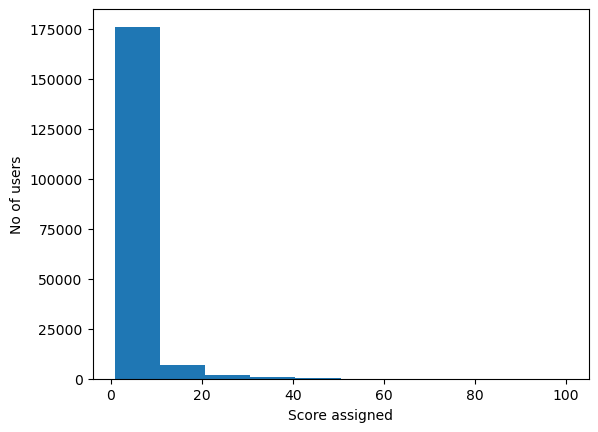

In [98]:
df_avg_duration = df_all.groupBy("buyer").agg(avg("duration").alias("avg_duration"))
# score4 based on num_currency
df_rule_avg_duration_pd=df_avg_duration.toPandas()
hist, bins=pd.cut(df_rule_avg_duration_pd['avg_duration'],bins=100,labels=False,retbins=True,right=False)
df_rule_avg_duration_pd['Score5']=hist
df_rule_avg_duration_pd['Score5']+=1
print(df_rule_avg_duration_pd)
#print unique score5 values assigned
print(df_rule_avg_duration_pd['Score5'].unique())
#plot histogram
plt.hist(df_rule_avg_duration_pd["Score5"])
plt.xlabel("Score assigned")
plt.ylabel("No of users")
plt.title("")
plt.show()
#converting to sparkdf
df_rule_avg_duration=spark.createDataFrame(df_rule_avg_duration_pd)

In [30]:
type(df_avg_duration)

pyspark.sql.dataframe.DataFrame

# Feature Extraction for Model

In [31]:
# modeldata = reduce(lambda x,y: pd.merge(x,y, on='buyer', how='outer'), [df_avg, df_count, df_num_nftcontract, df_currency, df_avg_duration])
joined_df = df_avg.join(df_count, on='buyer', how='inner').join(df_num_nftcontract, on='buyer', how='inner').join(df_currency, on='buyer', how='inner').join(df_avg_duration, on='buyer', how='inner')

In [32]:
joined_df.show(5)

23/03/29 10:47:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 10:47:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 10:47:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:50 WARN RowBasedKeyValueBatch: Calling spill() on

23/03/29 10:47:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 10:47:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 10:47:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 10:47:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:57 WARN RowBasedKeyValueBatch: Calling spill() on

23/03/29 10:47:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:47:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 10:48:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 10:48:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 10:48:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:05 WARN RowBasedKeyValueBatch: Calling spill() on

23/03/29 10:48:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 10:48:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 10:48:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 10:48:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:13 WARN RowBasedKeyValueBatch: Calling spill() on

23/03/29 10:48:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 10:48:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 10:48:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/03/29 10:48:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/03/29 10:48:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------+-------------------+-----------+---------------+------------+------------------+
|               buyer|          avg_spent|number_txns|num_nftcontract|num_currency|      avg_duration|
+--------------------+-------------------+-----------+---------------+------------+------------------+
|\x000000000027634...|-1094.1415000000002|          2|              2|           1|         1012977.0|
|\x0000002b94395a5...| 18.830347000000003|          1|              1|           1|           53640.0|
|\x00052fb2f4c461b...|         5686.01735|          2|              2|           2|         1696346.0|
|\x0005bb8bdcbbf4a...| 288.20619921428573|          7|              7|           1|256193.85714285713|
|\x0007a07be3fc1a3...|-305.52065600000003|          1|              1|           1|          208449.0|
+--------------------+-------------------+-----------+---------------+------------+------------------+
only showing top 5 rows



In [33]:
joined_df.count()

186035

In [109]:
joined_scores = df_rule_avg_spent.join(df_rule_number_txns, on='buyer', how='inner').join(df_rule_num_nftcontract, on='buyer', how='inner').join(df_rule_num_currency, on='buyer', how='inner').join(df_rule_avg_duration, on='buyer', how='inner')
joined_scores.show(5)

23/03/29 15:22:03 WARN TaskSetManager: Stage 359 contains a task of very large size (1280 KiB). The maximum recommended task size is 1000 KiB.
23/03/29 15:22:03 WARN TaskSetManager: Stage 360 contains a task of very large size (1126 KiB). The maximum recommended task size is 1000 KiB.
23/03/29 15:22:03 WARN TaskSetManager: Stage 361 contains a task of very large size (1126 KiB). The maximum recommended task size is 1000 KiB.


23/03/29 15:22:04 WARN TaskSetManager: Stage 362 contains a task of very large size (1126 KiB). The maximum recommended task size is 1000 KiB.
23/03/29 15:22:04 WARN TaskSetManager: Stage 363 contains a task of very large size (1280 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-------------------+------+-----------+------+---------------+------+------------+------+------------------+------+
|               buyer|          avg_spent|Score1|number_txns|Score2|num_nftcontract|Score3|num_currency|Score4|      avg_duration|Score5|
+--------------------+-------------------+------+-----------+------+---------------+------+------------+------+------------------+------+
|\x000000000027634...|-1094.1415000000002|    27|          2|     1|              2|     1|           1|     1|         1012977.0|     2|
|\x0000002b94395a5...| 18.830347000000003|    27|          1|     1|              1|     1|           1|     1|           53640.0|     1|
|\x00052fb2f4c461b...|         5686.01735|    27|          2|     1|              2|     1|           2|    34|         1696346.0|     2|
|\x0005bb8bdcbbf4a...| 288.20619921428573|    27|          7|     1|              7|     1|           1|     1|256193.85714285713|     1|
|\x0007a07be3fc1a3...|-305.5206560